<a href="https://colab.research.google.com/github/meghutch/Breast-Cancer-Classification-Wisconsin/blob/master/Breast_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **11.15.2019: Definitely errors in this. Will need to re-code in a fashion simiarly to Breast Cancer Clinical and Genetic Analysis.**

# **Breast Cancer Classification**

**Author:** Meg Hutch

**Date:** October 22, 2019


**Objective:** Classify Breast Cancer Tumnors as Malignant or Benign from the Breast Cancer Wisconin Dataset downloaded fromn https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

**Additional reference:** https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

**Dataset:** The following is the given data descriptions: 

**Attribute Information:**

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

1.   ID Number
2.   Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus (3-32):

3.  radius (mean of distances from center to points on the perimeter)
4.  texture (standard deviation of gray-scale values)
5.  perimeter
6.  area
7.  smoothness (local variation in radius lengths)
8.  compactness (perimeter^2 / area - 1.0)
9.  concavity (severity of concave portions of the contour)
10. concave points (number of concave portions of the contour)
11. symmetry
12. fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

**WIP Updates**

**11.01.2019: MH implemented the code for logisitic regression, will need to add random forest, and also ensure the neural network is okay**

**11.04.2019: MH is not sure if I need the train_x or val_x to also be converted to long format ; I'm having problems getting the models to run due to dimension problems**

**11.05.2019: MH will try revising the code for xb, yb and in regards to the data loader -- I think this is the problem. First though, I will save what I've done to github**

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

# Connect Colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import Data
tumor = pd.read_csv('/content/drive/My Drive/Projects/Breast_Cancer_Wisconsin/data.csv')

# View data
tumor.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


# **Explore Data**

First, we will examine the worst values obtained from each patient.

Total Number of Patients: 569
Number Diagnosed: diagnosis
B    357
M    212
dtype: int64
Percent Benign: 0.6
Percent Malignant: 0.4


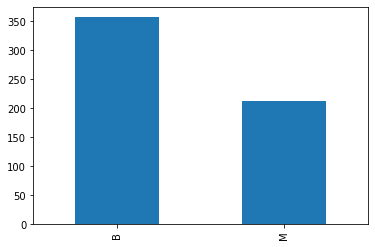

In [0]:
tumor.diagnosis.value_counts().plot(kind="bar")
count_dx = tumor.groupby(['diagnosis']).size()
print('Total Number of Patients:', len(tumor.index))
print('Number Diagnosed:', count_dx)
print('Percent Benign: {:.1f}'.format(357/len(tumor.index)))
print('Percent Malignant: {:.1f}'.format(212/len(tumor.index)))


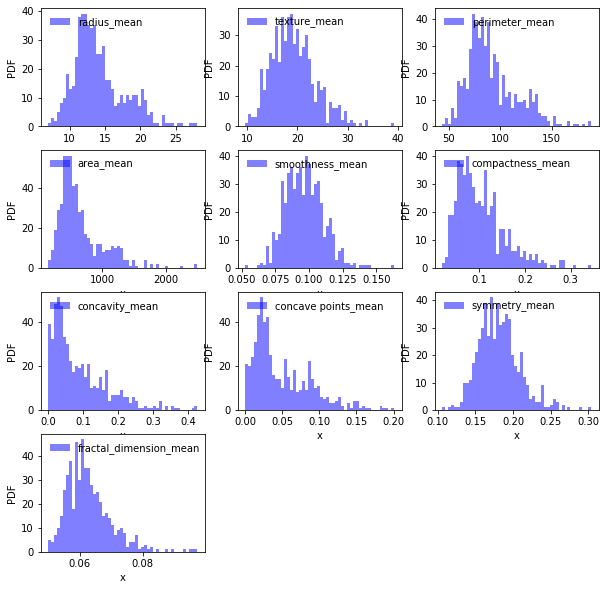

In [0]:
# Create a new dataframe to just contain columns of interset
tumor_plots = tumor[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]

# Generically define how many plots along and across
ncols = 3
nrows = int(np.ceil(len(tumor_plots.columns) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

# Lazy counter so we can remove unwanted axes
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(tumor_plots.columns):

            ax.hist(tumor_plots[tumor_plots.columns[counter]], bins=50, color='blue', alpha=0.5, label='{}'.format(tumor_plots.columns[counter]))
            ax.set_xlabel('x')
            ax.set_ylabel('PDF')
            leg = ax.legend(loc='upper left')
            leg.draw_frame(False)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()

# **Correlations for Feature Selection**

I'll eventually have to learn how to look into this more, as of now, I'm just going to include all features

In [0]:
# Basic correlogram
#sns.pairplot(tumor_plots)
#plt.show()

In [0]:
tumor.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# **Logistic Regression**

We will first try and assess classification using a simple logistic regression - this will also serve as a bench mark once we develop our neural network classifier

These steps were followed from the following tutorial: https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

In [0]:
# Packages 
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Create dummy variables for diagnoses

In [0]:
tumor['diagnosis'] = tumor.diagnosis.map({'B':0, 'M':1})

Create data frames into features and labels


In [0]:
# create x to represent the input features; y is the label; 
x = tumor[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
y = tumor.diagnosis # This is output of our training data

Split the data into testing and training

In [0]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=0)

Develop the logistic regression model

In [0]:
# instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1])

**Model Evaulation using Confusion Matrix**

In [0]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[85,  5],
       [ 6, 47]])

The confusion matrix generated abouve is in the form of an array. Diagonal values represent accurate predictions, while non-diagnonal elements are inaccurate predictions. The diagnoal starting with the top left to the bottom right hand corner are the actual predictions, while the bottom left corner to the top right corner are incorrect predictions.

In [0]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9230769230769231
Precision: 0.9038461538461539
Recall: 0.8867924528301887


**ROC**

The Reciever Operating Characteristic (ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificty

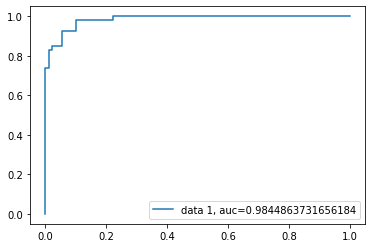

In [0]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# **Random Forest Classification**

## **PyTorch Neural Network for Classification**


In [0]:
# Import PyTorch packages
import torch
from torch import nn
from torchvision import datasets, transforms
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F

First need to create a test set. For this we will choose 20% of the data and define the function that can split the data 

In [0]:
# Function that randomly shuffles and splits the dataset
def split_indices(n, val_pct):
  # Determine size of test/validation set
  n_val = int(val_pct*n)
  # Create random permutation of 0 to n-1
  idxs = np.random.permutation(n)
  # Pick first n_val indices for test/validation set
  return idxs[n_val:], idxs[:n_val]

In [0]:
train_indices, test_indices = split_indices(len(tumor), val_pct=0.2)

print(len(train_indices), len(test_indices))
print('Sample test indices: ' , test_indices[:20])

456 113
Sample test indices:  [466 378   6 388 246 212 522 139 427 155 535 567 564 439  36 514 235 213
 137 498]


In [0]:
# Create a test set
test_ds = tumor[tumor.index.isin(test_indices)]

# Rename the train at tumor
tumor = tumor[tumor.index.isin(train_indices)]

Now we can apply this function once more, to create a training and validaiton set

In [0]:
train_indices, val_indices = split_indices(len(tumor), val_pct=0.2)

print(len(train_indices), len(val_indices))
print('Sample val indices: ' , val_indices[:10])

365 91
Sample val indices:  [ 99 294 275 430  58 426 361  54 269 369]


**Create a Training Set**

In [0]:
from torch.utils.data.dataloader import DataLoader

# Create training set
train_ds = tumor[tumor.index.isin(train_indices)]

# Using the training dataset just created, remove the diagnosis variable and create training feature and label vector
xb = train_ds[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
yb = train_ds.diagnosis # This is output of our training data

# Convert data into arrays
xb = np.array(xb, dtype = "float32")
yb = np.array(yb, dtype= "float32")

# Convert arrays into tensors
xb = torch.from_numpy(xb)
yb = torch.from_numpy(yb)

#Combine the arrays 
trainloader = TensorDataset(xb, yb) 

# Define the batchsize
batch_size=25

# Training Loader
trainloader = DataLoader(trainloader, 
                         batch_size)

**Similarly, Create the Validation Set**

In [0]:
from torch.utils.data.dataloader import DataLoader

# Create validation set
val_ds = tumor[tumor.index.isin(val_indices)]

# Using the validation dataset just created, remove the diagnosis variable and create validaiton feature and label vector
xb = val_ds[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
yb = val_ds.diagnosis # This is output of our validation data

# Convert data into arrays
xb = np.array(xb, dtype = "float32")
yb = np.array(yb, dtype= "float32")

# Convert arrays into tensors
xb = torch.from_numpy(xb)
yb = torch.from_numpy(yb)

#Combine the arrays 
val_loader = TensorDataset(xb, yb) 

# Define the batchsize
batch_size=25

# Validation Loader
val_loader = DataLoader(val_loader, 
                         batch_size)

# **Building the Neural Network**

In [0]:
input_size = 10 # we have 10 input features 
num_classes = 2 # we have two output labels, benign and melignant

# Logistic regression model
model = nn.Linear(input_size, num_classes) # nn.Linear can automatically intialize the weights and biases

In [0]:
model

Linear(in_features=10, out_features=2, bias=True)

In [0]:
print(model.weight.shape)
model.weight

torch.Size([2, 10])


Parameter containing:
tensor([[-0.1051,  0.2481, -0.1211, -0.1061, -0.2512, -0.0791, -0.1006, -0.1609,
         -0.1343, -0.2405],
        [ 0.2779,  0.0908,  0.0653,  0.0885,  0.2427, -0.2273,  0.1712,  0.0514,
          0.1464,  0.0635]], requires_grad=True)

In [0]:
for xb, yb in trainloader:
  print(xb.shape)
  outputs = model(xb)
  break

torch.Size([25, 10])


In [0]:
class MnistModel(nn.Module):
  def __init__(self): # we instantiate the weights and biases
    super().__init__() 
    self.linear = nn.Linear(input_size, num_classes)
    
  def forward(self,xb): # we flatten out the input tensor, and then pass it into self.linear
    #xb = xb.reshape(-1, 10) # indicates to PyTorch that we want a view of the xb tensor with two dimensions, where the length along the 2nd dimension is 10 - on argument to .reshape can be set to -1 (in this case, the first dimension), to let PyTorch figure it out automatically based on the shape of the original tensor
    out = self.linear(xb)
    return out
  
model = MnistModel() 

In [0]:
for xb, yb in trainloader:
    outputs = model(xb)
    break

print('outputs.shape :', outputs.shape)
print('Sample outputs :\n', outputs[:25].data)

outputs.shape : torch.Size([25, 2])
Sample outputs :
 tensor([[ 41.5482, 298.3881],
        [ 49.5197, 385.8391],
        [ 22.8668, 151.4234],
        [ 25.7748, 180.2547],
        [ 23.9148, 164.4720],
        [ 32.7782, 236.4822],
        [ 44.1785, 334.0110],
        [ 26.1198, 181.5109],
        [ 27.8512, 203.6594],
        [ 28.9599, 209.0604],
        [ 25.8216, 175.8746],
        [ 31.3120, 216.1190],
        [ 51.3201, 407.6683],
        [ 36.1047, 270.5147],
        [ 37.8163, 274.0720],
        [ 42.3922, 322.9756],
        [ 30.6620, 224.1849],
        [ 38.7983, 284.6359],
        [ 42.1250, 322.6516],
        [ 36.1661, 270.2856],
        [ 44.1159, 342.7989],
        [ 33.9064, 244.2837],
        [ 35.3669, 261.6093],
        [ 28.8530, 213.4727],
        [ 25.0818, 174.8681]])


In [0]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1) # The softmax function requires us to specify a dimension along which the softmax must be applied

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum:", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0., 1.],
        [0., 1.]])
Sum: 1.0


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. This is done using torch.max, which returns the largest element and the index of the largest element along a particular dimension of a tensor

In [0]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1])


Now we can compare with the actual labels (MH thinks this should be with the train_y dataset since we are seeing whether the model was able to learn from the train_x set?

In [0]:
yb

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.])

# **Evaluation Metric and Loss Function**

We need a way to evaluate how well our model is performing. For this reason, we can use cross entropy. 

Cross Entropy works as follows: 

* For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are [0.1, 0.3, 0.2,...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest.
* Then, take the logarithm of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiple the result by -1, which results in a large positive value of the loss for poor predictions. 
* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data. 

Cross-entropy is continuous and differentiable that provides a good feedback for incremental improvments in the model (a slightly higher probability for the correct label leads to a lower loss). 

PyTorch provides an efficient and tensor-friendly implementation of cross-entropy. It also performs a softmax internally so we can directly pass in the outputs of the model without converting them into probabilities. 



In [0]:
loss_fn = F.cross_entropy

# **Optimizer**

we can use the optim.SGD to update the weights and biases during training

In [0]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate)

Parameters like batch size and learning rate, etc, need to be picked in advance while training machine learning models and are called hyperparametesr. Picking the right hyperparameters is critical for training an accurate model within a reasonable amount of time.

# **Training the Model**

After defining the data loaders, model, loss function and optimizer, we are ready to train the model. 

First, we can begin by defining a function loss_batch which:


*   Calculates the loss for a batch of data
*   Optionally performs the gradient descent update step in an optimizer is provided
*   Optionally computes a metric (e.g. accuracy) using the predictions and actual targets 



In [0]:
def loss_batch(model, loss_func, xb, yb,
               opt=None, metric=None):
  
  # Calculate loss
  preds = model(xb)
  loss = loss_func(preds, yb)

  xb = xb.long()
  yb = yb.long()
  loss = loss.long()
  
  if opt is not None: # The optimizer is an optional arguement, to ensure that we can reuse loss_batch for computing the loss on the validation set
    # Compute gradients
    loss.backward()
    # Update parameters
    opt.step()
    # Reset gradients
    opt.zero_grad()
    
  metric_result = None
  if metric is not None:
      # Compute the metric
      metric_result = metric(preds, yb) # Computes the accuracy
      
  return loss.item(), len(xb), metric_result

Next, define a function evaluate, which calculates the overall loss (and a metric if provided) for the validaiton set

In [0]:
def evaluate(model, loss_fn, valid_dl, metric=None):
  with torch.no_grad(): # no_grad indicates to PyTorch that we shouldn't track, calculate, or modify gradients while updating the weights and biases
    # Pass each batch through the model
    results = [loss_batch(model, loss_fn, 
                          xb, yb, metric=metric)
              for xb,yb in valid_dl]
    # Separate losses, counts and metrics
    losses, nums, metrics = zip(*results)
    # Total size of the dataset
    total = np.sum(nums)
    # Avg. loss across batches
    total_loss = np.sum(np.multiply(losses, nums))
    avg_loss = total_loss / total
    avg_metric = None
    if metric is not None: 
      # Avg. of metric across batches
      tot_metric = np.sum(np.multiply(metrics, nums))
      avg_metric = tot_metric / total
  return avg_loss, total, avg_metric

Also need to redefine the accuracy to operate on an entire batch of outputs directly, so that we can use it as a metric in fit.

In [0]:
def accuracy(outputs, yb):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == yb).item() / len(preds)

Note: We don't need to apply softmax to the outputs since it doesn't change the relative order of the results. This is because e^x is an increasing function. if y1 > y2, then e^y1 > e^y2 and the same holds true averaging out the values to get the softmax 

Examine how the model performs on the validation set with the initital set of weights and biases

In [0]:
val_loss, total, val_acc = evaluate(
    model, loss_fn, val_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'
     .format(val_loss, val_acc))

RuntimeError: ignored

# **DRAFTS**

Create training and validation sets for the data and then apply the indices

In [0]:
# Create training set
train_ds = tumor[tumor.index.isin(train_indices)]

# Create a validation set
val_ds = tumor[tumor.index.isin(val_indices)]

Create data loaders for the training and validation set. But first, remove the diagnosis variable from the x sets

In [0]:
# Using the training dataset just created, remove the diagnosis variable and create training feature and label vector
train_x = train_ds[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
train_y = train_ds.diagnosis # This is output of our training data

# do the same with the testing set
val_x = val_ds[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']] # taking test data inputs
val_y = val_ds.diagnosis   #output value of test dat

Convert data into arrays

In [0]:
# Convert data into arrays
train_x = np.array(train_x, dtype = "float32")
train_y = np.array(train_y, dtype= "float32")

val_x = np.array(val_x, dtype = "float32")
val_y = np.array(val_y, dtype= "float32")

In [0]:
len(train_x)
#len(val_x)

In [0]:
# Convert arrays into tensors
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

val_x = torch.from_numpy(val_x)
val_y = torch.from_numpy(val_y)

Now we can create the dataloader 

In [0]:
from torch.utils.data import TensorDataset

#Combine the arrays 
trainloader = TensorDataset(train_x, train_y) 
val_loader = TensorDataset(val_x, val_y) 

In [0]:
# Define the batchsize
batch_size=25

# Training Loader
trainloader = DataLoader(trainloader, 
                         batch_size)

# Validation Data Loader
val_loader = DataLoader(val_loader, 
                         batch_size)

# **Building the Neural Network**

In [0]:
input_size = 10 # we have 10 input features 
num_classes = 2 # we have two output labels, benign and melignant

# Logistic regression model
model = nn.Linear(input_size, num_classes) # nn.Linear can automatically intialize the weights and biases

In [0]:
model

In [0]:
print(model.weight.shape)
model.weight

In [0]:
for train_x, train_y in trainloader:
  print(train_x.shape)
  outputs = model(train_x)
  break

In [0]:
class MnistModel(nn.Module):
  def __init__(self): # we instantiate the weights and biases
    super().__init__() 
    self.linear = nn.Linear(input_size, num_classes)
    
  def forward(self, train_x): # we flatten out the input tensor, and then pass it into self.linear
    #train_x = train_x.reshape(-1, 10) # indicates to PyTorch that we want a view of the xb tensor with two dimensions, where the length along the 2nd dimension is 10 - on argument to .reshape can be set to -1 (in this case, the first dimension), to let PyTorch figure it out automatically based on the shape of the original tensor
    out = self.linear(train_x)
    return out
  
model = MnistModel() 

In [0]:
for train_x, train_y in trainloader:
    outputs = model(train_x)
    break

print('outputs.shape :', outputs.shape)
print('Sample outputs :\n', outputs[:25].data)

In [0]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1) # The softmax function requires us to specify a dimension along which the softmax must be applied

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum:", torch.sum(probs[0]).item())

Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. This is done using torch.max, which returns the largest element and the index of the largest element along a particular dimension of a tensor

In [0]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)

Now we can compare with the actual labels (MH thinks this should be with the train_y dataset since we are seeing whether the model was able to learn from the train_x set?

In [0]:
train_y

# **Evaluation Metric and Loss Function**

We need a way to evaluate how well our model is performing. For this reason, we can use cross entropy. 

Cross Entropy works as follows: 

* For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are [0.1, 0.3, 0.2,...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest.
* Then, take the logarithm of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiple the result by -1, which results in a large positive value of the loss for poor predictions. 
* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data. 

Cross-entropy is continuous and differentiable that provides a good feedback for incremental improvments in the model (a slightly higher probability for the correct label leads to a lower loss). 

PyTorch provides an efficient and tensor-friendly implementation of cross-entropy. It also performs a softmax internally so we can directly pass in the outputs of the model without converting them into probabilities. 



In [0]:
loss_fn = F.cross_entropy
#loss_fn = torch.nn.BCELoss()

In [0]:
# Convert the torches to long format - this seems to enable the loss_fn below
train_x = train_x.long()
train_y = train_y.long()

val_x = val_x.long()
val_y = val_y.long()

In [0]:
# Loss for current batch of data
loss = loss_fn(outputs, yb)
print(loss) 

ValueError: ignored

Since the cross entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples, one way to interpret the resulting number for example 7.6, is to look at e^-7.6 (0.0005), as the predicted probability of the correct label on average.

The lower the loss, the better the model.

# **Optimizer**

we can use the optim.SGD to update the weights and biases during training

In [0]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate)

Parameters like batch size and learning rate, etc, need to be picked in advance while training machine learning models and are called hyperparametesr. Picking the right hyperparameters is critical for training an accurate model within a reasonable amount of time.

# **Training the Model**

After defining the data loaders, model, loss function and optimizer, we are ready to train the model. 

First, we can begin by defining a function loss_batch which:


*   Calculates the loss for a batch of data
*   Optionally performs the gradient descent update step in an optimizer is provided
*   Optionally computes a metric (e.g. accuracy) using the predictions and actual targets 



In [0]:
def loss_batch(model, loss_func, train_x, train_y,
               opt=None, metric=None):

  # Calculate loss
  preds = model(train_x)
  loss = loss_func(preds, train_y)
  
  if opt is not None: # The optimizer is an optional arguement, to ensure that we can reuse loss_batch for computing the loss on the validation set
    # Compute gradients
    loss.backward()
    # Update parameters
    opt.step()
    # Reset gradients
    opt.zero_grad()
    
  metric_result = None
  if metric is not None:
      # Compute the metric
      metric_result = metric(preds, train_y) # Computes the accuracy
      
  return loss.item(), len(train_x), metric_result

Next, define a function evaluate, which calculates the overall loss (and a metric if provided) for the validaiton set

In [0]:
def evaluate(model, loss_fn, valid_dl, metric=None):
  with torch.no_grad(): # no_grad indicates to PyTorch that we shouldn't track, calculate, or modify gradients while updating the weights and biases
    # Pass each batch through the model
    results = [loss_batch(model, loss_fn, 
                          val_x, val_y, metric=metric)
              for val_x, val_y in valid_dl]
    # Separate losses, counts and metrics
    losses, nums, metrics = zip(*results)
    # Total size of the dataset
    total = np.sum(nums)
    # Avg. loss across batches
    total_loss = np.sum(np.multiply(losses, nums))
    avg_loss = total_loss / total
    avg_metric = None
    if metric is not None: 
      # Avg. of metric across batches
      tot_metric = np.sum(np.multiply(metrics, nums))
      avg_metric = tot_metric / total
  return avg_loss, total, avg_metric

Also need to redefine the accuracy to operate on an entire batch of outputs directly, so that we can use it as a metric in fit.

In [0]:
def accuracy(outputs, train_y):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == train_y).item() / len(preds)

Note: We don't need to apply softmax to the outputs since it doesn't change the relative order of the results. This is because e^x is an increasing function. if y1 > y2, then e^y1 > e^y2 and the same holds true averaging out the values to get the softmax 

Examine how the model performs on the validation set with the initital set of weights and biases

In [0]:
val_loss, total, val_acc = evaluate(
    model, loss_fn, val_loader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'
     .format(val_loss, val_acc))

In [0]:
type(loss_fn)


In [0]:
train_x.type

In [0]:
#train_y.numel()
train_x.numel()

# **#DRAFTS**

In [0]:
# Create a model
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc1 = nn.Linear(10, 5)
      self.fc2 = nn.Linear(5, 2)
      
  def forward(self, x):
      # make sure input tensor is flattened
      #x = train_x.view(train_x.shape[0], -1)
      #x = train_x.reshape(-1, 10)
      
      x = F.relu(self.fc1(x))
      x = F.log_softmax(self.fc2(x), dim=1)
      
      return(x)

In [0]:
class TwoLayerNet(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    
    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension
    """
    super(TwoLayerNet, self).__init__()
    self.linear1 = nn.Linear(D_in, H) 
    self.linear2 = nn.Linear(H, D_out)
  
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must 
    return a Variable of output data. We can use Modules defined in the 
    constructor as well as arbitrary operators on Variables.
    """
    h_relu = F.relu(self.linear1(x))
    y_pred = self.linear2(h_relu)
    return y_pred

In [0]:
# N is batch size; D_in is input dimension;
# H is the dimension of the hidden layer; D_out is output dimension.
N, D_in, H, D_out = 10, 10, 5, 2

# Create random Tensors to hold inputs and outputs, and wrap them in Variables
#x = Variable(torch.randn(N, D_in))  # dim: 32 x 100

x = train_x.reshape(10, 10)

# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Forward pass: Compute predicted y by passing x to the model
y_pred = model(x)   # dim: 32 x 10

Run the model...not sure if running into problems due to the vector needing to be flattened or problems with the trainloader? 

In [0]:
x = train_x.reshape(-1, 10)

In [0]:
x

In [0]:
model = Classifier()

train_x, train_y = next(iter(testloader))

# Get the class probabilities 
ps = torch.exp(model(train_x))

# Make sure the shape is appropriate
print(ps.shape)

In [0]:
# Define the model with one hidden layer
model = nn.Sequential(nn.Linear(10, 5),
                      nn.ReLU(),
                      nn.Linear(5, 2),
                      nn.LogSoftmax(dim=1))

# Set optimizer and learning rate
optimizer = optim.SGD(model.parameters(), lr=0.03)

# Could also use Adam optimizer; similar to stochastic gradient descent, but uses momentum which can speed up the actual fitting process, and it also adjusts the learning rate for each of the individual parameters in the model
# optimizer = optim.Adam(model.parameters(), lr=0.003)

# Define the loss
criterion = nn.NLLLoss()

# Set 5 epochs to start
epochs = 5
for e in range(epochs):
    running_loss = 0
    for train_x, train_y in trainloader:
      # Flatten data into a vector 
        #train_x = train_x.view(train_x.shape[0], -1)
        #try the reshape method
        #train_x = train_x.reshape(-1, 10)
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        # Training pass
        output = model.forward(train_x)
        loss = criterion(output, train_y) # Loss calculated from the output compard to the labels 
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # loss.item() gets the scalar value held in the loss. Running_loss = 0, 
        # += notation, says "Add a value and the variable and assigns the result to that variable." So, adds the running_loss (0) with loss.item and assigns to running_loss
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

In [0]:
train_x.numel()

In [0]:
batch_size=100

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices) #will sample elements randomly from a given list of indices, while creating batches of data
train_loader = DataLoader(tumor, 
                         batch_size,
                         sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(tumor, 
                       batch_size, 
                       sampler=val_sampler)

In [0]:
train_X = train[prediction_var]# taking the training data input 
train_y = train.diagnosis # This is output of our training data
# same we have to do for test
test_X= test[prediction_var] # taking test data inputs
test_y =test.diagnosis   #output value of test data

In [0]:
train_X = train[prediction_var]# taking the training data input 
train_y=train.diagnosis# This is output of our training data
# same we have to do for test
test_X= test[prediction_var] # taking test data inputs
test_y =test.diagnosis   #output value of test dat

In [0]:
#now split our data into train and test
train, test = train_test_split(tumor, test_size = 0.3)# in this our main data is split into train and test
# we can check their dimension
print(train.shape)
print(test.shape)

In [0]:
##Drafts!!!!!

In [0]:
# Convert dfs to arrays
inputs = np.array(inputs, dtype = "float32")
labels = np.array(labels, dtype= "float32")

Transform the data into arrays and then convert to tensors

In [0]:
# Convert arrays to tensors
inputs = torch.from_numpy(inputs)
labels = torch.from_numpy(labels)

Need to divide the data into a training and test set. Define a function to split the dataset:

In [0]:
from torch.utils.data import TensorDataset, DataLoader

#Define dataset
train_ds = TensorDataset(inputs, labels)

In [0]:
# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

In [0]:
# The DataLoader is typically used in a for-in loop
for xb, yb in train_dl:
  print(xb)
  print(yb)
  break

**nn.Linear**

nn.Linear can be used to autmoatically initialize the weights and biases, rather than having to do so manually

**I have to assess whether this is actually working. I'm concerned with how to set the nn.Linear functions. Also, I think I need to apply softmax to turn into a proabability.**

In [0]:
# Define model
model = nn.Linear(10, 569)
print(model.weight)
print(model.bias)

In [0]:
# Parameters - returns a list containing all the weights and bias matrices present in the model. For our linear regression model, we have one weight matrix and one bias matrix.
list(model.parameters())

In [0]:
# Generate predictions
preds = model(inputs)
preds 

**Loss Function**

Instead of defining a loss function manually, we can use the built-in loss function mse_loss

In [0]:
# Import nn.functional
import torch.nn.functional as F

#These package contains many useful loss functions and several other utilities

In [0]:
# Define loss function
loss_fn = F.mse_loss

In [0]:
# Compute the loss for the current predictions of our model
loss = loss_fn(model(inputs), labels)
print(loss)

In [0]:
# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

#The model.parameters() is passed as an argument to optim.SGD so that the optimizer knows which matrices should be modified during the update step. 
#We can also specify a learning rate which controls the amount by which the parameters are modified

**Train the Model**

We will train the model with the same steps but using batches of data. The utility function **fit** trains the model for a given number of epochs

1.   Generate predictions
2.   Calculate the loss
3.   Compute the gradients w.r.t the weights and biases
4.   Adjust the weights by subtracting a small quantity proportional to the gradient
5.   Reset the gradients to zero

In [0]:
# Utility function to train the model
def fit(num_epochs, model, loss_fn, opt):
  
  # Repeat for given number of epochs:
  for epoch in range(num_epochs):
    
    #Train with batches of data
    for xb, yb in train_dl:
      
      # 1. Generate predictions
      pred = model(xb)
      
      # 2. Calculate loss
      loss = loss_fn(pred, yb)
      
      # 3. Compute Gradients
      loss.backward()
      
      # 4. Update parameters using gradients
      opt.step()
      
      # 5. Reset the gradients to zero
      opt.zero_grad()
      
    # Print the progress
    if (epoch+1) % 10 == 0:
      print('Epoch [{}/{}, Loss: {:.4f}' .format(
          epoch+1, num_epochs, loss.item()))
      
# We use the data loader defined earlier to get batches of data for every iteration
# Instead of updating parameters (weights and biases) manually, we use opt.step to perform the update, and opt.zero_grad to reset the gradients to zero
# We've also added a log statement which prints the loss from the last batch of data for every 10th epoch, to track the progress of training. 
# loss.item returns the actual value stored in the loss tensor

In [0]:
# Train the model for 100 epochs
fit(100, model, loss_fn, opt)

In [0]:
# Generate predictions to verify that our model is close to our targets
preds = model(inputs)
preds

In [0]:
# Compare with labels
labels

In [0]:
##DRAFTS BELOW######

In [0]:
class MnistModel(nn.Module):
  """Feedforward neural network with 1 hidden layer"""
  def __init__(self, in_size, hidden_size, out_size):
      super().__init__()
      # hidden layer
      self.linear1 = nn.Linear(in_size, hidden_size)
      # output layer
      self.linear2 = nn.Linear(hidden_size, out_size)
    
  def forward(self, xb):
      # Get intermediate outputs using hidden layers
      out = self.linear1(xb)
      # Apply activation function
      out = F.relu(out)
      # Get predictions using output layer
      out = self.linear2(out)
      return out

In [0]:
input_size = 9
num_classes = 2

model = MnistModel(input_size, hidden_size=3, # 3 nodes  
                   out_size=num_classes)

In [0]:
for t in model.parameters():
  print(t.shape)

In [0]:
for xb, yb in train_dl:
    outputs = model(xb)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('Outputs.shape:', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

In [0]:
# Define the model with one hidden layer
model = nn.Sequential(nn.Linear(9, 3),
                      nn.ReLU(),
                      nn.Linear(3, 2),
                      nn.LogSoftmax(dim=1))

# Set optimizer and learning rate
optimizer = optim.SGD(model.parameters(), lr=0.03)

# Could also use Adam optimizer; similar to stochastic gradient descent, but uses momentum which can speed up the actual fitting process, and it also adjusts the learning rate for each of the individual parameters in the model
# optimizer = optim.Adam(model.parameters(), lr=0.003)

# Define the loss
criterion = nn.NLLLoss()

# Set 5 epochs to start
epochs = 5
for e in range(epochs):
    running_loss = 0
    for inputs, labels in trainloader:
       
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        # Training pass
        output = model.forward(images)
        loss = criterion(output, labels) # Loss calculated from the output compard to the labels 
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # loss.item() gets the scalar value held in the loss. Running_loss = 0, 
        # += notation, says "Add a value and the variable and assigns the result to that variable." So, adds the running_loss (0) with loss.item and assigns to running_loss
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        


In [0]:
# Create a model
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc1 = nn.Linear(9, 3)
      self.fc2 = nn.Linear(3, 3)
      self.fc4 = nn.Linear(3, 2)
      
  def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = F.log_softmax(self.fc4(x), dim=1)
      
      return(x)

In [0]:
model = Classifier()

images = next(iter(testloader))

# Get the class probabilities 
ps = torch.exp(model(images))

# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

# **Create Further Subgroups Based on Characteristics and do Multi-Class Classification**